In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import fairseq
from models.testbench import Wav2vec_U
import torch.nn.functional as F

In [2]:
val_feats = np.load("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.npy")

In [3]:
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.tsv", "r") as f:
    lines = f.readlines()
audio_path = lines[0]
audio_ids = []
for audio_id in lines[1:]:
    audio_ids.append(audio_id.split('\t')[0].split('/')[1])
    
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.phn", "r") as f:
    phone_transcripts = f.readlines()
    
with open("/home/santiago.cuervo/data/fairseqProcessed/LibriSpeech-no-silence/valid.lengths", "r") as f:
    seq_lens = f.readlines()
seq_lens = [int(l) for l in seq_lens]

In [4]:
dataset = np.split(val_feats, np.cumsum(seq_lens)[:-1])

In [5]:
len(audio_ids), len(phone_transcripts), len(seq_lens), len(dataset)

(2864, 2864, 2864, 2864)

Text(0.5, 1.0, 'Wav2vec representations for sample 3660-172183-0002.wav')

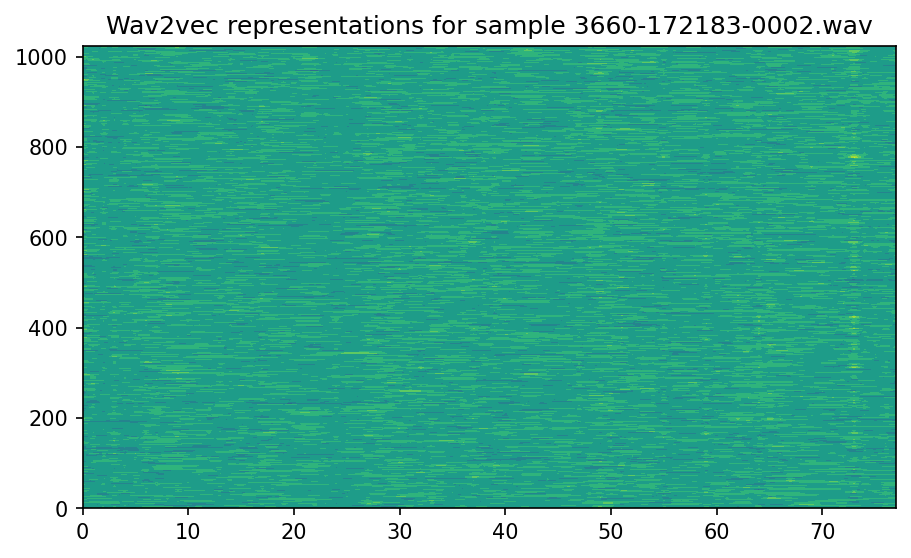

In [6]:
sample_idx = 11
x = np.arange(0, seq_lens[sample_idx])
y = np.arange(0, val_feats.shape[1])
X, Y = np.meshgrid(x, y)
Z = dataset[sample_idx].T
Z = Z / np.sqrt((Z**2).sum(1, keepdims=True))

plt.figure(figsize=(7, 4), dpi=150)
plt.contourf(X, Y, Z, 10)
plt.title(f"Wav2vec representations for sample {audio_ids[sample_idx]}")

In [34]:
cp = '/home/santiago.cuervo/ssl/mywav2vec/multirun/2023-01-15/10-22-32/0/checkpoint_last.pt'

model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp])
model = model[0]
model.eval()

Wav2vec_U(
  (discriminator): Discriminator(
    (net): Sequential(
      (0): Conv1d(43, 384, kernel_size=(8,), stride=(1,), padding=(7,))
      (1): SamePad()
      (2): Dropout(p=0.0, inplace=False)
      (3): Sequential(
        (0): Conv1d(384, 384, kernel_size=(8,), stride=(1,), padding=(7,))
        (1): SamePad()
        (2): Dropout(p=0.0, inplace=False)
        (3): GELU(approximate='none')
      )
      (4): Conv1d(384, 1, kernel_size=(8,), stride=(1,), padding=(7,))
      (5): SamePad()
    )
  )
  (segmenter): JoinSegmenter()
  (generator): Generator(
    (dropout): Dropout(p=0.1, inplace=False)
    (boundary_predictor): BoundaryPredictor(
      (proj): TransformerEncoder(
        (pos_conv): Sequential(
          (0): Conv1d(1024, 1024, kernel_size=(128,), stride=(1,), padding=(64,), groups=16)
          (1): SamePad()
          (2): GELU(approximate='none')
        )
        (layers): ModuleList(
          (0): TransformerSentenceEncoderLayer(
            (self_attn): Mu

In [44]:
x = torch.FloatTensor(dataset[sample_idx]).unsqueeze(0)
padding_mask = torch.zeros(x.size(0), x.size(1)).bool()
print(x.size(), padding_mask.size())

torch.Size([1, 78, 1024]) torch.Size([1, 78])


In [45]:
gen_result = model.generator(x, None, padding_mask)
print(gen_result.keys())

dict_keys(['inter_x', 'log_probs', 'pred_log_probs', 'dense_x', 'token_x', 'dense_padding_mask'])


In [52]:
boundaryProbs = gen_result["log_probs"][:, :, 1].view(-1).exp()

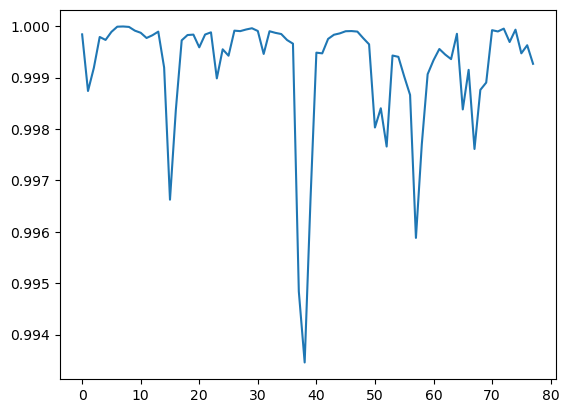

In [53]:
plt.plot(boundaryProbs.detach().numpy())

In [54]:
sample_len = 8
AVG_PHONE_DURATION = 3.790364
all_segments_len_sample_probs = F.unfold(gen_result["log_probs"].view(-1, 2)[:, 1].exp().view(1, 1, -1, 1), (sample_len, 1))
expected_num_boundaries = all_segments_len_sample_probs.sum(1)
len_prior_loss = (expected_num_boundaries.mean() - (sample_len / AVG_PHONE_DURATION))**2
len_prior_loss

tensor(34.6084, grad_fn=<PowBackward0>)